In [ ]:
# set working dictionary
import os
import sys
from google.colab import drive

drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive/ECE661/FinalProject')
sys.path.append('/content/drive/MyDrive/ECE661/FinalProject')


##################################

# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime 
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)


Mounted at /content/drive
device: cuda


# Download Data - Cifar10

In [ ]:
 

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]), download=True),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])),
    batch_size=100, shuffle=False)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            predicted_labels = torch.argmax(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n



Files already downloaded and verified


# Model Define

- Teacher Model ： ResNet18
- Student Model ： VGG13

## Utility Fucntions

In [ ]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, scheduler, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
        scheduler.step()

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)



## ResNet18


In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2]).to(DEVICE)

## VGG13

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)




def VGG13():
    return VGG('VGG13').to(DEVICE)


# Normal Train

## Train VGG

In [ ]:
import os.path

RANDOM_SEED = 1234
RES18_CP = "ResNet18_new_ground_truth_91.pt"

torch.manual_seed(RANDOM_SEED)

model_student = ResNet18()

if os.path.exists(RES18_CP):

  # load model Directly
  print("==========> Load Parameters")
  model_student.load_state_dict(torch.load(RES18_CP))
  
else:

  # If model not trained 
  print("==========> Not find checkpoint, train")

  N_EPOCHS = 40

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model_student.parameters(), lr=0.01,
               momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  model_student, optimizer, _ = training_loop(model_student, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE, scheduler)

  # Save model 
  torch.save(model_student.state_dict(), RES18_CP)


## Train ResNet


In [ ]:
import os.path

RANDOM_SEED = 1234
TEACHER_VGG13_CP = "VGG13_cifar_ground_truth.pt"

torch.manual_seed(RANDOM_SEED)

model_teacher = VGG('VGG13').to(DEVICE)

if os.path.exists(TEACHER_VGG13_CP):

  # load model Directly
  print("==========> Load Parameters")
  model_teacher.load_state_dict(torch.load(TEACHER_VGG13_CP))
  
else:

  # If model not trained 
  print("==========> Not find checkpoint, train")

  N_EPOCHS = 40

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model_teacher.parameters(), lr=0.01,
               momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


  model_student, optimizer, _ = training_loop(model_teacher, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE, scheduler)

  # Save model 
  torch.save(model_teacher.state_dict(), TEACHER_VGG13_CP)

# KD Utility Fucntions

In [ ]:
def plot_losses_soft(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train_soft(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def training_loop_soft(model, train_criterion, valid_criterion, scheduler, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_soft(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
        scheduler.step()

    # save metrics
    plot_losses_soft(train_losses, valid_losses, params['title'])

    str_time = datetime.now().strftime("%m-%d_%H-%M")
    
    return model, optimizer, (train_losses, valid_losses)

class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Reverse KD


In [ ]:
# Train
temperatures = [8, 10, 15, 20]
N_EPOCHS = 40
ALPHA = 0.95

VGG13_CP = "VGG13_cifar_ground_truth.pt"
model_teacher = VGG13()
model_teacher.load_state_dict(torch.load(VGG13_CP))

for t in temperatures:

    model_student = ResNet18()

    print(f"=======> Temperature: {t}")
 
    optimizer = optim.SGD(model_student.parameters(), lr=0.01,
               momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    valid_criterion = nn.CrossEntropyLoss()
    train_criterion = SoftCrossEntropyLoss(t, ALPHA)

    prefix = f"student_T{t}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"

    #if not os.path.exists(dir_path):
    #    os.makedirs(dir_path, exist_ok=True)
    
    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{t} α{ALPHA}"
         }

    model_student, optimizer, _ = training_loop_soft(model_student, train_criterion, valid_criterion, scheduler, optimizer, train_loader, val_loader,
                                        N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
    
    torch.save(model_student.state_dict(), f"ResNet18_learn_from_Vgg13_t{t}.pt")   

# Teacher-Free KD 

## ResNet18

=======> Temperature: 2
23:01:33 --- Epoch: 0	Train loss: 4.6775	Valid loss: 1.8032	Train accuracy: 54.09	Valid accuracy: 53.92
23:02:48 --- Epoch: 1	Train loss: 2.7745	Valid loss: 0.9270	Train accuracy: 73.70	Valid accuracy: 73.57
23:04:02 --- Epoch: 2	Train loss: 1.9627	Valid loss: 0.8974	Train accuracy: 77.76	Valid accuracy: 76.79
23:05:17 --- Epoch: 3	Train loss: 1.5499	Valid loss: 0.7650	Train accuracy: 80.35	Valid accuracy: 80.31
23:06:32 --- Epoch: 4	Train loss: 1.2896	Valid loss: 0.7430	Train accuracy: 81.86	Valid accuracy: 80.28
23:07:47 --- Epoch: 5	Train loss: 1.1069	Valid loss: 0.5601	Train accuracy: 86.02	Valid accuracy: 84.34
23:09:02 --- Epoch: 6	Train loss: 0.9657	Valid loss: 0.6073	Train accuracy: 86.27	Valid accuracy: 84.10
23:10:17 --- Epoch: 7	Train loss: 0.8556	Valid loss: 0.5950	Train accuracy: 87.03	Valid accuracy: 84.51
23:11:31 --- Epoch: 8	Train loss: 0.7691	Valid loss: 0.5136	Train accuracy: 89.09	Valid accuracy: 86.19
23:12:46 --- Epoch: 9	Train loss: 0.6897

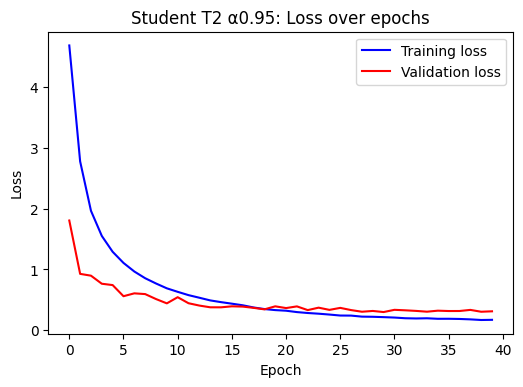

=======> Temperature: 5
23:52:16 --- Epoch: 0	Train loss: 9.7869	Valid loss: 2.0184	Train accuracy: 61.71	Valid accuracy: 61.17
23:53:31 --- Epoch: 1	Train loss: 5.1285	Valid loss: 1.2044	Train accuracy: 73.52	Valid accuracy: 74.20
23:54:45 --- Epoch: 2	Train loss: 3.3580	Valid loss: 0.9327	Train accuracy: 80.90	Valid accuracy: 80.36
23:56:00 --- Epoch: 3	Train loss: 2.5168	Valid loss: 0.8995	Train accuracy: 82.38	Valid accuracy: 81.34
23:57:14 --- Epoch: 4	Train loss: 2.0379	Valid loss: 0.8081	Train accuracy: 85.15	Valid accuracy: 83.32
23:58:29 --- Epoch: 5	Train loss: 1.6841	Valid loss: 0.6244	Train accuracy: 88.07	Valid accuracy: 86.29
23:59:43 --- Epoch: 6	Train loss: 1.4443	Valid loss: 0.5480	Train accuracy: 90.02	Valid accuracy: 87.29
00:00:58 --- Epoch: 7	Train loss: 1.2360	Valid loss: 0.5716	Train accuracy: 89.78	Valid accuracy: 87.60
00:02:12 --- Epoch: 8	Train loss: 1.1080	Valid loss: 0.5270	Train accuracy: 91.02	Valid accuracy: 87.85
00:03:25 --- Epoch: 9	Train loss: 0.9917

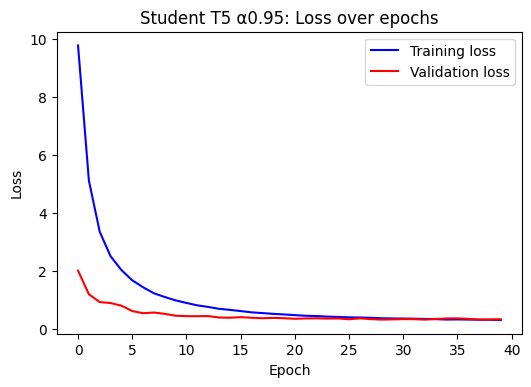

=======> Temperature: 10
00:42:05 --- Epoch: 0	Train loss: 8.4565	Valid loss: 2.1787	Train accuracy: 60.56	Valid accuracy: 60.03
00:43:20 --- Epoch: 1	Train loss: 4.2825	Valid loss: 1.2505	Train accuracy: 75.72	Valid accuracy: 75.11
00:44:35 --- Epoch: 2	Train loss: 2.7910	Valid loss: 0.9208	Train accuracy: 81.77	Valid accuracy: 80.79
00:45:50 --- Epoch: 3	Train loss: 2.0899	Valid loss: 0.7840	Train accuracy: 85.30	Valid accuracy: 83.47
00:47:05 --- Epoch: 4	Train loss: 1.6660	Valid loss: 0.6797	Train accuracy: 87.39	Valid accuracy: 85.44
00:48:22 --- Epoch: 5	Train loss: 1.3733	Valid loss: 0.5612	Train accuracy: 89.51	Valid accuracy: 87.68


KeyboardInterrupt: ignored

In [ ]:
# Train
temperatures = [2, 5]
N_EPOCHS = 40
ALPHA = 0.95

RES18_CP = "ResNet18_new_ground_truth_91.pt"
model_teacher = ResNet18()
model_teacher.load_state_dict(torch.load(RES18_CP))

for t in temperatures:

    print(f"=======> Temperature: {t}")

    model_student = ResNet18()
 
    optimizer = optim.SGD(model_student.parameters(), lr=0.01,
               momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    valid_criterion = nn.CrossEntropyLoss()
    train_criterion = SoftCrossEntropyLoss(t, ALPHA)

    prefix = f"student_T{t}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"

    #if not os.path.exists(dir_path):
    #    os.makedirs(dir_path, exist_ok=True)
    
    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{t} α{ALPHA}"
         }

    model_student, optimizer, _ = training_loop_soft(model_student, train_criterion, valid_criterion, scheduler, optimizer, train_loader, val_loader,
                                        N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
    
    torch.save(model_student.state_dict(), f"ResNet18_self_kd_t{t}.pt")   



## VGG 13

=======> Temperature: 2
00:49:52 --- Epoch: 0	Train loss: 4.0118	Valid loss: 1.5877	Train accuracy: 59.85	Valid accuracy: 61.09
00:50:53 --- Epoch: 1	Train loss: 2.1792	Valid loss: 1.0659	Train accuracy: 73.48	Valid accuracy: 72.79
00:51:54 --- Epoch: 2	Train loss: 1.6030	Valid loss: 0.7889	Train accuracy: 78.55	Valid accuracy: 78.33
00:52:56 --- Epoch: 3	Train loss: 1.2673	Valid loss: 0.8135	Train accuracy: 79.49	Valid accuracy: 78.82
00:53:57 --- Epoch: 4	Train loss: 1.0613	Valid loss: 0.6770	Train accuracy: 83.59	Valid accuracy: 81.75
00:54:59 --- Epoch: 5	Train loss: 0.9165	Valid loss: 0.6190	Train accuracy: 84.87	Valid accuracy: 83.06
00:56:00 --- Epoch: 6	Train loss: 0.8082	Valid loss: 0.5668	Train accuracy: 87.07	Valid accuracy: 85.19
00:57:02 --- Epoch: 7	Train loss: 0.7176	Valid loss: 0.4887	Train accuracy: 88.45	Valid accuracy: 86.49
00:58:03 --- Epoch: 8	Train loss: 0.6442	Valid loss: 0.5906	Train accuracy: 86.95	Valid accuracy: 84.46
00:59:05 --- Epoch: 9	Train loss: 0.5917

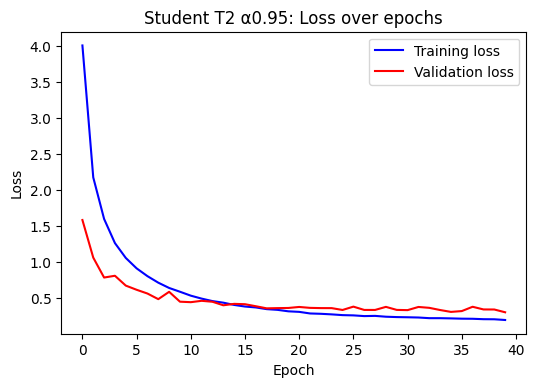

=======> Temperature: 5
01:30:47 --- Epoch: 0	Train loss: 8.9640	Valid loss: 2.1709	Train accuracy: 60.07	Valid accuracy: 60.50
01:31:49 --- Epoch: 1	Train loss: 4.1180	Valid loss: 0.9981	Train accuracy: 76.07	Valid accuracy: 76.92
01:32:50 --- Epoch: 2	Train loss: 2.7112	Valid loss: 0.8256	Train accuracy: 82.13	Valid accuracy: 81.12
01:33:51 --- Epoch: 3	Train loss: 2.0715	Valid loss: 0.7017	Train accuracy: 84.35	Valid accuracy: 83.50
01:34:53 --- Epoch: 4	Train loss: 1.6732	Valid loss: 0.7444	Train accuracy: 85.20	Valid accuracy: 83.20
01:35:54 --- Epoch: 5	Train loss: 1.3962	Valid loss: 0.6026	Train accuracy: 87.70	Valid accuracy: 85.35
01:36:55 --- Epoch: 6	Train loss: 1.2147	Valid loss: 0.5344	Train accuracy: 88.93	Valid accuracy: 86.82
01:37:57 --- Epoch: 7	Train loss: 1.0858	Valid loss: 0.5480	Train accuracy: 88.99	Valid accuracy: 86.37
01:38:58 --- Epoch: 8	Train loss: 0.9789	Valid loss: 0.5049	Train accuracy: 90.67	Valid accuracy: 87.65
01:40:00 --- Epoch: 9	Train loss: 0.8930

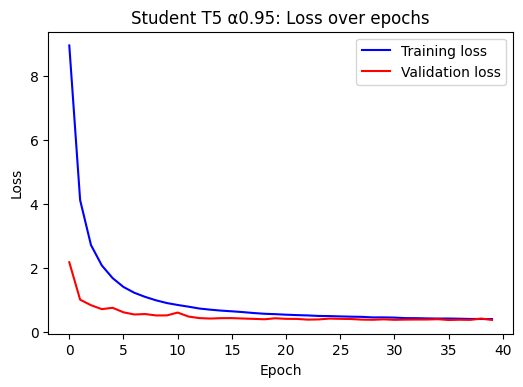

In [ ]:
# Train
temperatures = [2, 5]
N_EPOCHS = 40
ALPHA = 0.95

VGG13_CP = "VGG13_cifar_ground_truth.pt"
model_teacher = VGG13()
model_teacher.load_state_dict(torch.load(VGG13_CP))

for t in temperatures:

    print(f"=======> Temperature: {t}")

    model_student = VGG13()
 
    optimizer = optim.SGD(model_student.parameters(), lr=0.01,
               momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    valid_criterion = nn.CrossEntropyLoss()
    train_criterion = SoftCrossEntropyLoss(t, ALPHA)

    prefix = f"student_T{t}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"

    #if not os.path.exists(dir_path):
    #    os.makedirs(dir_path, exist_ok=True)
    
    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{t} α{ALPHA}"
         }

    model_student, optimizer, _ = training_loop_soft(model_student, train_criterion, valid_criterion, scheduler, optimizer, train_loader, val_loader,
                                        N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
    
    torch.save(model_student.state_dict(), f"VGG13_self_kd_t{t}.pt")   

# Net Architecture

In [ ]:
!pip install pthflops
!pip install torchsummary

  Created wheel for pthflops: filename=pthflops-0.4.1-py3-none-any.whl size=10063 sha256=a4f54510a2c458d5193b38b51107c726646f6b5dc4f3eac0aef3d6966bfcb1bc
  Stored in directory: /root/.cache/pip/wheels/9c/41/05/475bdaebaaf3a44f25367a8dc0ac9d4b8edbb7f5fa19724c70
Successfully built pthflops


In [ ]:
from pthflops import count_ops
from torchsummary import summary

model_teacher = ResNet18()
 
summary(model_teacher, (3, 32, 32))
count_ops(model_teacher, torch.rand(1,3,32,32).to(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

(557143050,
 [['conv1', 1769472],
  ['bn1', 131072],
  ['layer1_0_conv1', 37748736],
  ['layer1_0_bn1', 131072],
  ['layer1_0_conv2', 37748736],
  ['layer1_0_bn2', 131072],
  ['add', 131072],
  ['layer1_1_conv1', 37748736],
  ['layer1_1_bn1', 131072],
  ['layer1_1_conv2', 37748736],
  ['layer1_1_bn2', 131072],
  ['add_1', 131072],
  ['layer2_0_conv1', 18874368],
  ['layer2_0_bn1', 65536],
  ['layer2_0_conv2', 37748736],
  ['layer2_0_bn2', 65536],
  ['layer2_0_shortcut_0', 2097152],
  ['layer2_0_shortcut_1', 65536],
  ['add_2', 65536],
  ['layer2_1_conv1', 37748736],
  ['layer2_1_bn1', 65536],
  ['layer2_1_conv2', 37748736],
  ['layer2_1_bn2', 65536],
  ['add_3', 65536],
  ['layer3_0_conv1', 18874368],
  ['layer3_0_bn1', 32768],
  ['layer3_0_conv2', 37748736],
  ['layer3_0_bn2', 32768],
  ['layer3_0_shortcut_0', 2097152],
  ['layer3_0_shortcut_1', 32768],
  ['add_4', 32768],
  ['layer3_1_conv1', 37748736],
  ['layer3_1_bn1', 32768],
  ['layer3_1_conv2', 37748736],
  ['layer3_1_bn2', 327

In [ ]:
model_student = VGG13()

summary(model_student, (3, 256, 256))
count_ops(model_student, torch.rand(1,3,256,256).to(DEVICE))

RuntimeError: ignored